#### Content
* [Fetch a scRNA-seq dataset](#1) and store it as h5ad format
* Perform [differential gene expression analysis](#2) and [gene set enrichment analysis](#3)
* Access and store gene sets,e.g.,[GO-BP](#4), [GO-CC](#5) (require an intermediate file of GSEA)

In [1]:
options(warn=-1)
# options(warn=0)

In [2]:
library(Seurat)
library(SeuratDisk)
library(SeuratData)
library(EnhancedVolcano)
library(clusterProfiler)
library(org.Hs.eg.db)
library(GO.db)
library(jsonlite)
source("src/func.R")

Attaching SeuratObject

Registered S3 method overwritten by 'SeuratDisk':
  method            from  
  as.sparse.H5Group Seurat

── Installed datasets ───────────────────────────────────────────────────────────────────────────── SeuratData v0.2.1 ──

✔ pbmc3k 3.1.4                                              


────────────────────────────────────────────────────────── Key ─────────────────────────────────────────────────────────

✔ Dataset loaded successfully
❯ Dataset built with a newer version of Seurat than installed
❓ Unknown version of Seurat installed


Loading required package: ggplot2

Loading required package: ggrepel

Registered S3 methods overwritten by 'ggalt':
  method                  from   
  grid.draw.absoluteGrob  ggplot2
  grobHeight.absoluteGrob ggplot2
  grobWidth.absoluteGrob  ggplot2
  grobX.absoluteGrob      ggplot2
  grobY.absoluteGrob      ggplot2



Registered S3 method overwritten by 'ggtree':
  method      from 
  identify.gg ggfun

clusterProfiler v4.2.2

Load and save dataset

Reference: https://mojaveazure.github.io/seurat-disk/articles/convert-anndata.html
<a class="anchor" id="1"></a>

In [3]:
InstallData("pbmc3k")
data("pbmc3k.final")

In [5]:
pbmc <- LoadData("pbmc3k", type = "pbmc3k.final")

In [6]:
pbmc@meta.data$cell.type  <- as.character(Idents(pbmc))
SaveH5Seurat(pbmc, filename = "pbmc3k.h5Seurat")
Convert("pbmc3k.h5Seurat", dest = "h5ad")

Creating h5Seurat file for version 3.1.5.9900

Adding counts for RNA

Adding data for RNA

Adding scale.data for RNA

Adding variable features for RNA

Adding feature-level metadata for RNA

Adding cell embeddings for pca

Adding loadings for pca

No projected loadings for pca

Adding standard deviations for pca

Adding JackStraw information for pca

Adding cell embeddings for umap

No loadings for umap

No projected loadings for umap

No standard deviations for umap

No JackStraw data for umap

Validating h5Seurat file

Adding scale.data from RNA as X

Transfering meta.features to var

Adding data from RNA as raw

Transfering meta.features to raw/var

Transfering meta.data to obs

Adding dimensional reduction information for pca

Adding feature loadings for pca

Adding dimensional reduction information for umap

Adding RNA_snn as neighbors



In [7]:
table(Idents(pbmc))


 Naive CD4 T Memory CD4 T   CD14+ Mono            B        CD8 T FCGR3A+ Mono 
         697          483          480          344          271          162 
          NK           DC     Platelet 
         155           32           14 

In [8]:
pbmc.filter  <- subset(pbmc, idents = c("Naive CD4 T", "Memory CD4 T", "CD14+ Mono", "B", "CD8 T"))

Differentially expressed genes, CD4 memory T cells vs other groups of cells
<a class="anchor" id="2"></a>

In [9]:
# Memory CD4 
markers <- FindMarkers(pbmc.filter, ident.1 = "Memory CD4 T")
# view results
head(markers)

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
IL32,8.058895e-82,1.1561579,0.948,0.491,1.105197e-77
LTB,4.244276e-66,1.0861369,0.981,0.681,5.820600e-62
B2M,5.061253e-57,0.3895980,1.000,0.999,6.941002e-53
IL7R,1.271916e-51,1.0166557,0.747,0.358,1.744305e-47
TNFRSF4,1.301893e-51,0.9618996,0.213,0.023,1.785416e-47
CD2,3.001009e-51,1.1606799,0.652,0.258,4.115583e-47


Gene set enrichment analysis

GO-BP
<a class="anchor" id="3"></a>

In [10]:
gene.list = sort(markers$avg_log2FC, decreasing  = TRUE)
names(gene.list) = rownames(markers)
res.gsea <- gseGO(gene         = gene.list,
                OrgDb         = org.Hs.eg.db,
                keyType       = 'SYMBOL',
                ont           = "BP",
                pAdjustMethod = "BH",
                pvalueCutoff  = 0.05,
                minGSSize    = 10,
                maxGSSize    = 200,
                by = 'fgsea'
                  )

preparing geneSet collections...

GSEA analysis...

leading edge analysis...

done...



Dotplot of enriched gene sets with high-ranking NES values

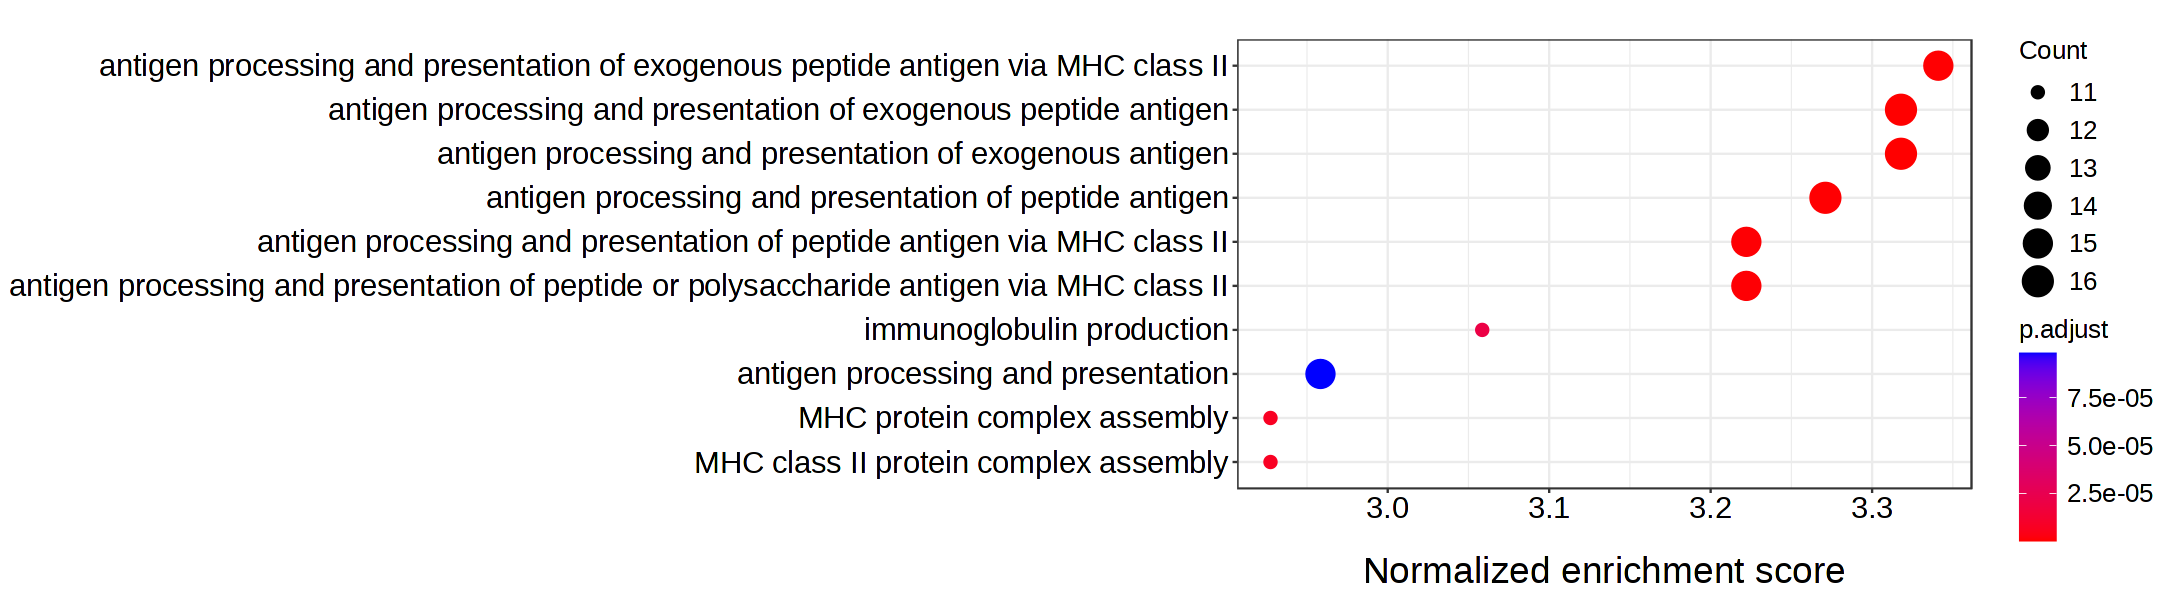

In [10]:
order = "NES"
res.gsea.order <- order.gsea(res.gsea, order)
saved <- options(repr.plot.width=18, repr.plot.height=5)
g <- dotplot(res.gsea.order, showCategory=10,
        x = order, font.size = 18, 
        label_format = 100) +
  xlab("Normalized enrichment score")+
  theme(legend.key.size = unit(0.8, 'cm'), 
        legend.key.height = unit(0.8, 'cm'), 
        legend.key.width = unit(0.8, 'cm'),
        legend.margin=margin(t = 0, unit='cm'),
        legend.justification = "top",
        legend.box.spacing = unit(1, "cm"),
        legend.title = element_text(size=15), 
        legend.text = element_text(size=15),
        axis.title.x = element_text(size = 22, margin = margin(t = 20))) 
g


<a class="anchor" id="4"></a>

In [12]:
### files for gene sets are stored as json files
### ID, names, constituent symbols of gene sets
GO.BP.TERM <- select(GO.db, keys=names(res.gsea@geneSets), columns=c("TERM"))$'TERM'
write_json(res.gsea@geneSets, "BP.json")
write_json(GO.BP.TERM, "BP.TERM.json")

'select()' returned 1:1 mapping between keys and columns



GO-CC

In [ ]:
gene.list = sort(markers$avg_log2FC, decreasing  = TRUE)
names(gene.list) = rownames(markers)
res.gsea.cc <- gseGO(gene         = gene.list,
                OrgDb         = org.Hs.eg.db,
                keyType       = 'SYMBOL',
                ont           = "CC",
                pAdjustMethod = "BH",
                pvalueCutoff  = 0.05,
                minGSSize    = 10,
                maxGSSize    = 200,
                by = 'fgsea'
                  )
### ID, names, containing symbols of gene sets
GO.CC.TERM <- select(GO.db, keys=names(res.gsea@geneSets), columns=c("TERM"))$'TERM'
write_json(res.gsea@geneSets, "CC.json")
write_json(GO.CC.TERM, "CC.TERM.json")

preparing geneSet collections...

GSEA analysis...



In [70]:
### setSize means the size of the intersection between a gene set and the list of DEGs
length(intersect(res.gsea@geneSets$'GO:0032946', names(gene.list)))

In [18]:
# saveRDS(res.gsea, "res.gsea.rds")
res.gsea <- readRDS("res.gsea.rds")

<a class="anchor" id="5"></a>